In [11]:
# Recurrent Neural Networks (RNN)

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# dataset_train: we only need the second column (open = [1]) to train our dataset.
#.iloc[:, 1:2].values: means all rows and and first column
#.values provides us to turn this data frame into a numpy array. without it the output is still a dataframe
training_set = dataset_train.iloc[:, 1:2].values

print(type(training_set))

print(training_set)

<class 'numpy.ndarray'>
[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]


In [45]:
# Feature Scaling (Normalisation)
'''
Normalization - scale variables to have value between 0 and 1
Standardization - data transformed has mean 0 and Standard Deviation 1
'''
# we use normalisation scaling technique, instead of standardisation. This is recommended in this type of analysis
# whenever you build an RNN, especially when the sigmoid function is the activation function, use normalisation

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
# we are going to create a data structure specifying what the RNN will need to remember when predicting the next stock price
#and this is called the number of timesteps. this is super important to have the correct number of timestamps cause it could lead to overfitting
# 60 timesteps mean that at each time t the RNN is going to look at 60 stock prices before time t
# the stock price is between 60 days before time t and time t. 
#based on the trends it's capturing during this 60 days timesteps, it will try to predict the next output
# 60 is the experimented timestep for this prediction

X_train = []
y_train = []
for i in range(60, 1258):
    # Creates the 60 timesteps of each value. E.g. row 1 = 0 -> 59, row 2 = 1 -> 60
    X_train.append(training_set_scaled[i-60:i, 0])
    # Contains the next value after the 60 timesteps. E.g. row 1 = last value of row 2, row 2 = last value of row 3
    # This is used to predict the next value (future value)
    # y array contains the value (just after the range(i, i+60)) of normalized open column
    y_train.append(training_set_scaled[i, 0])
# Convert to numpy array to be accepted in our RNN
X_train, y_train = np.array(X_train), np.array(y_train)

# X_train is the input 
# y_train is the output
# range(60, 1258): between 60th financial day and 1258 is the last index in our set

print((X_train.shape))
print(y_train.shape)

(1198, 60)
(1198,)


In [60]:
# 1.5: RESHAPING:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#input shape: the input should be a 3d array
#adding some more dimensionality. we will add the unit. 
#that is the number of predictors we want
#X_train.shape[0]: batch size= the number of observations. 1198 observations. you can have this in any dataset. because this line gives the number of rows
#X_train.shape[1]: number of timesteps: this is the number of columns
#1: number of indicators= number of predictors

# we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.
X_train.shape

(1198, 60, 1)

In [61]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
# allow us to create a neural network object representing a sequence of layers

from keras.layers import Dense, LSTM, Dropout
# Dense to add output layer
# LSTM to add LSTM layer
# Dropout to add some dropout regularization

# Initialising the RNN
regressor = Sequential()
# Sequential is the easiest way to build a model in Keras.
# It allows you to build a model layer by layer.
# since we are predicting a continous value, we are doing some regression. therefore we use the name regressor for our model. 
# classification, on the other hand, is about predicting a category.


# ADDING THE FIRST LSTM LAYER AND SOME DROPOUT REGULARIZATION:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))  
regressor.add(Dropout(0.2))
#arguments:
# units: the number of LSTM cells, or memory units (neurons) you want to have in this LSTM layer. 
# 50 neurons in this layer will get us a model with high dimentiality

# return_sequences: it's true because we are building a stacked LSTM which therefore have several LSTM layers

# once you are done with the LSTM layers, when you are not going to add another one, you will set it to false. false is the default value 

# input_shape: the shape of the input that we created in the last part
'''it's an input shape of three dimensions, corresponding to observations(number of rows), the timestep (number of columns) and the indicators.
   we don't have to include all the three dimensions "(X_train.shape[0], X_train.shape[1], 1)" we will just add the last two. 
   because the first one is corresponding to the observations, will be automatically taken into account
'''

# Dropout(0.2): the rate of neurons, you want to ignore in the layers. 0.2 is used generally. 20% dropout

'it\'s an input shape of three dimensions, corresponding to observations(number of rows), the timestep (number of columns) and the indicators.\n   we don\'t have to include all the three dimensions "(X_train.shape[0], X_train.shape[1], 1)" we will just add the last two. \n   because the first one is corresponding to the observations, will be automatically taken into account\n'

In [0]:
#2.4: ADDING THE SECOND, THIRD AND FOURTH LSTM LAYERS AND DROPOUTS:

# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# we only specify the shape of the input in the first layer

# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [63]:
# 2.5: ADDING THE OUTPUT LAYER:
regressor.add(Dense(units = 1))
# to make a full connection with the last lstm layer and the output, we use the dense class
#unit =1 the number of neurons that needs to be in the output
#since we're predicting a real value corresponding to the stock price, the output has only one dimension (neuron)

regressor

In [0]:
#2.6: COMPILING THE RNN WITH THE OPTIMIZER AND THE LOSS:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#compile is a method of sequential class
#mean_squared_error is good for regression


In [65]:
#2.7 FITTING THE RNN TO THE TRAINING SET:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
#we will update the stock prices in every 32 stock prices

Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0569
Epoch 2/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0071
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0057
Epoch 4/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0055
Epoch 5/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0051
Epoch 6/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0050
Epoch 7/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0048
Epoch 8/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0046
Epoch 9/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0045
Epoch 10/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0046
Epoch 11/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0039
Epoch 12/100
1198/1198 [==============================] - 5s 5ms/step - lo

In [77]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
#we already know the stock prices for january 2017, but the model is not trained on this.

# Getting the predicted stock price of 2017
# this is the predicted results for january 2017

#1. key point:
# we trained our model to be able to predict the stock prices according to previous 60 days
# and therefore, to predict each stock price of each financial day of Jan 2017, we will need the 60 previous stock prices, before the actual day.

#2. key point: 
# in order to get each day of jan 2017 the 60 previous stock prices, we will need both the training and test data
# because we will have some of the 60 days from the training set, becuase they will be from Dec 2016 and we will also have some from the jan
# therefore, we need concatinate the training and the test set.

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)

inputs = sc.transform(inputs)
# concat function: we united the two sets by rows (axis =0). we only have the 'open' column
# inputs: the stock prices of the 60 previous stock prices (equal to 3 months of financial day)
# len(dataset_total) - len(dataset_test) - 60: this is the lower bound
# upper bound is the last index
# inputs.reshape: this will get the inputs in one column
# sc.transform(inputs): scaling the inputs

X_test = []
# loop from 60 to 80 because test data has 20 values only
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#our test set only has 20 financial days (equals to 1 month=jan), therefore the upper bound is 80

(80, 1)


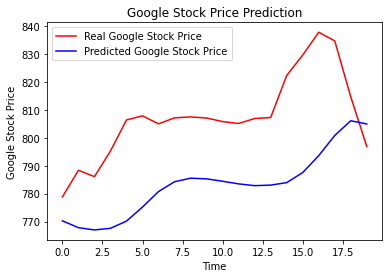

In [68]:

#3.3 Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [69]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

27.0645301665286